In [20]:
# Below is an example of CAFFE2 official example. But I add somthing here

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, use the LeNet CNN model
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Necessities imported!


## Model construction

For the sake of modularity, we have 4 parts

1. AddInput
2. Main computation
3. Training
4. Bookkeeping, where we just print out statistics for inspection

In [22]:
#AddInput

# Data Description
# MNIST data is stored as NCHW order
# MNIST data has shape of 28 * 28 px, uint8 dtype
# ===> [batch_size, 1, 28, 28]

# Processing
# For stability: [0, 255] -> [0, 1]（注意这里用了一个operator，所以我们后面要紧跟一个StopGradient让BP在这里停止）

from caffe2.python.helpers import db_input # 在lmdb_create_examples.py里面发现如果少了这要行要报错无法找到db_input

def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data, label = model.TensorProtosDBInput(
        [], ["data", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
#     data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [23]:
def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = brew.relu(model, layer, 'relu_{}'.format(i))
    softmax = brew.softmax(model, layer, 'softmax')
    return softmax

In [24]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

In [25]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

In [26]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [27]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

In [28]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

In [29]:
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=64,
    db='../data/caffe2_learning/raw_mnist/train_lmdb',
    db_type='lmdb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db='../data/caffe2_learning/raw_mnist/test_lmdb',
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")

BlobReference("softmax")

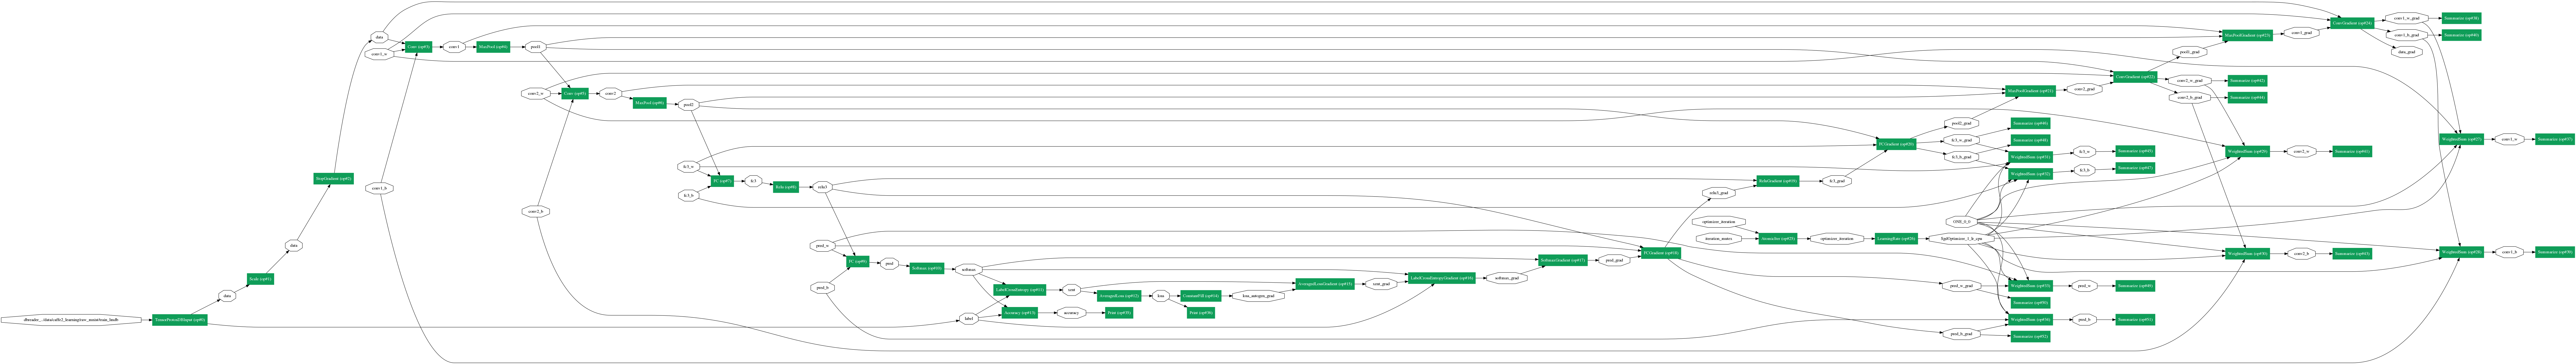

In [30]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

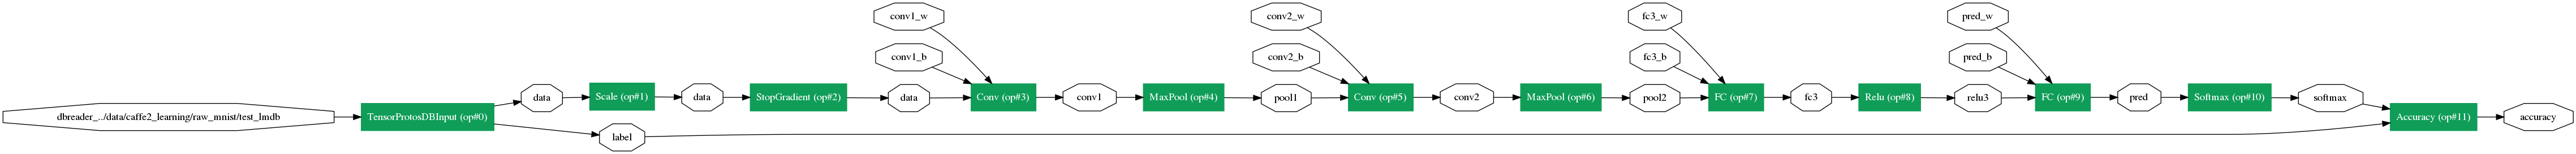

In [31]:
from IPython import display
graph = net_drawer.GetPydotGraph(test_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

In [32]:
train_model.param_init_net.Proto().op[0]

output: "dbreader_../data/caffe2_learning/raw_mnist/train_lmdb"
name: ""
type: "CreateDB"
arg {
  name: "db"
  s: "../data/caffe2_learning/raw_mnist/train_lmdb"
}
arg {
  name: "db_type"
  s: "lmdb"
}

In [33]:
test_model.param_init_net.Proto()

name: "mnist_test_init_1"
op {
  output: "dbreader_../data/caffe2_learning/raw_mnist/test_lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db"
    s: "../data/caffe2_learning/raw_mnist/test_lmdb"
  }
  arg {
    name: "db_type"
    s: "lmdb"
  }
}

In [34]:
test_model.net.Proto().op

[input: "dbreader_../data/caffe2_learning/raw_mnist/test_lmdb"
output: "data"
output: "label"
name: ""
type: "TensorProtosDBInput"
arg {
  name: "batch_size"
  i: 100
}
, input: "data"
output: "data"
name: ""
type: "Scale"
arg {
  name: "scale"
  f: 0.00390625
}
, input: "data"
output: "data"
name: ""
type: "StopGradient"
, input: "data"
input: "conv1_w"
input: "conv1_b"
output: "conv1"
name: ""
type: "Conv"
arg {
  name: "kernel"
  i: 5
}
arg {
  name: "order"
  s: "NCHW"
}
arg {
  name: "exhaustive_search"
  i: 0
}
engine: "CUDNN"
, input: "conv1"
output: "pool1"
name: ""
type: "MaxPool"
arg {
  name: "order"
  s: "NCHW"
}
arg {
  name: "cudnn_exhaustive_search"
  i: 0
}
arg {
  name: "kernel"
  i: 2
}
arg {
  name: "stride"
  i: 2
}
engine: "CUDNN"
, input: "pool1"
input: "conv2_w"
input: "conv2_b"
output: "conv2"
name: ""
type: "Conv"
arg {
  name: "kernel"
  i: 5
}
arg {
  name: "order"
  s: "NCHW"
}
arg {
  name: "exhaustive_search"
  i: 0
}
engine: "CUDNN"
, input: "conv2"
outpu

Iter: 0, Loss: 2.3594250679016113, Accuracy: 0.046875
Iter: 25, Loss: 0.42516452074050903, Accuracy: 0.921875
Iter: 50, Loss: 0.29210758209228516, Accuracy: 0.921875
Iter: 75, Loss: 0.5491969585418701, Accuracy: 0.8125
Iter: 100, Loss: 0.3925987482070923, Accuracy: 0.84375
Iter: 125, Loss: 0.2994181513786316, Accuracy: 0.90625
Iter: 150, Loss: 0.07246033102273941, Accuracy: 0.984375
Iter: 175, Loss: 0.15605983138084412, Accuracy: 0.96875


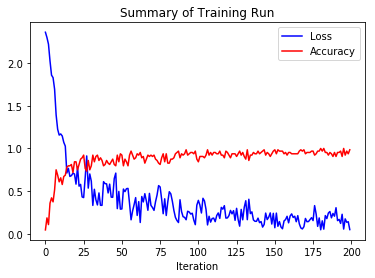

In [35]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

In [54]:
workspace.FetchBlob('conv2_b')

array([-2.9321924e-02, -7.9273842e-03, -1.7461823e-02, -3.2344062e-02,
       -4.4319681e-03, -2.0870822e-02, -5.6955353e-03, -2.1027723e-02,
       -1.8225538e-02, -2.2566054e-04,  5.4235351e-03, -1.0409089e-03,
       -1.3139617e-02, -8.5022608e-03, -1.4258035e-02, -4.1548435e-02,
       -3.1933006e-02, -1.8039271e-02, -1.5111588e-02,  8.5615373e-04,
        6.1040861e-05, -6.7314003e-03, -1.9555664e-02, -2.4240363e-02,
       -4.6889605e-03, -5.6040869e-04, -4.8862970e-03,  1.6933084e-03,
       -3.6544334e-02, -8.3555924e-03, -4.9334799e-04,  7.8936964e-03,
       -3.3871584e-02,  2.8701648e-03,  2.2012785e-03, -2.9234013e-02,
       -2.1950986e-02, -2.3051926e-03, -2.8470654e-02, -5.4748747e-03,
       -3.0024134e-02, -3.3104934e-02, -5.8236592e-03, -2.9618226e-02,
        3.6396130e-03, -7.9656206e-03,  5.7732537e-03, -2.9497819e-02,
       -2.4345726e-02,  4.6764985e-03], dtype=float32)

总结：这个lmdb文件我不知道哪里有问题但是就是不行，所以我自己找了一个MNIST data然后造了一个lmdb，于是可以了

## Visualize Results

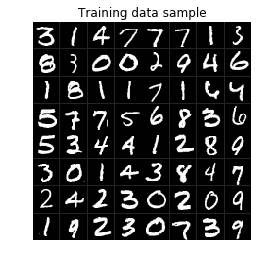

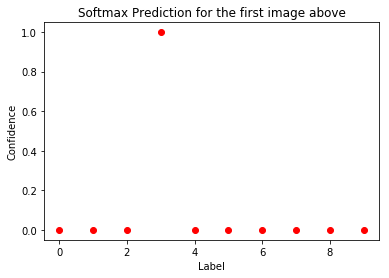

In [36]:
pyplot.figure()
pyplot.title('Training data sample')
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)

# visualize softmax results
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')

softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')

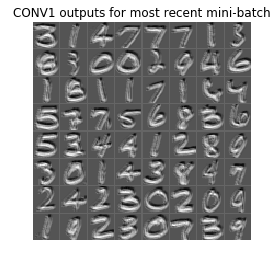

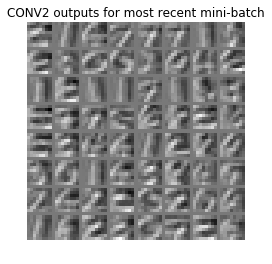

In [37]:
if USE_LENET_MODEL:
    pyplot.figure()
    pyplot.title('CONV1 outputs for most recent mini-batch')
    conv = workspace.FetchBlob('conv1')
    conv = conv[:,[3],:,:]    
    visualize.NCHW.ShowMultiple(conv)

    pyplot.figure()
    pyplot.title('CONV2 outputs for most recent mini-batch')
    conv = workspace.FetchBlob('conv2')
    conv = conv[:,[3],:,:]  
    visualize.NCHW.ShowMultiple(conv)
    

# Test Model

test_accuracy: 0.957000


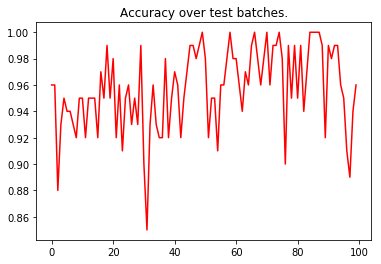

In [38]:
workspace.RunNetOnce(test_model.param_init_net) # 这里只有data reader部分变了，别的部分都没变，因为我们设置了init_params=False。这就保证了在workspace中别的param都还是一样的
workspace.CreateNet(test_model.net, overwrite=True)

test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.FetchBlob('accuracy')

pyplot.plot(test_accuracy, 'r')
pyplot.title('Accuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

# Deploy Model

In [39]:
import caffe2.python.predictor.mobile_exporter as me

In [40]:
workspace.Blobs()

['ONE_0_0',
 'SgdOptimizer_0_lr_cpu',
 'SgdOptimizer_1_lr_cpu',
 'accuracy',
 'conv1',
 'conv1_b',
 'conv1_b_grad',
 'conv1_grad',
 'conv1_w',
 'conv1_w_grad',
 'conv2',
 'conv2_b',
 'conv2_b_grad',
 'conv2_grad',
 'conv2_w',
 'conv2_w_grad',
 'data',
 'data_grad',
 'dbreader_../data/caffe2_learning/raw_mnist/test_lmdb',
 'dbreader_../data/caffe2_learning/raw_mnist/train_lmdb',
 'fc3',
 'fc3_b',
 'fc3_b_grad',
 'fc3_grad',
 'fc3_w',
 'fc3_w_grad',
 'iteration_mutex',
 'label',
 'loss',
 'loss_autogen_grad',
 'optimizer_iteration',
 'pool1',
 'pool1_grad',
 'pool2',
 'pool2_grad',
 'pred',
 'pred_b',
 'pred_b_grad',
 'pred_grad',
 'pred_w',
 'pred_w_grad',
 'relu3',
 'relu3_grad',
 'softmax',
 'softmax_grad',
 'xent',
 'xent_grad']

In [41]:
deploy_model.params

[BlobReference("conv1_w"),
 BlobReference("conv1_b"),
 BlobReference("conv2_w"),
 BlobReference("conv2_b"),
 BlobReference("fc3_w"),
 BlobReference("fc3_b"),
 BlobReference("pred_w"),
 BlobReference("pred_b")]

In [42]:
# 保存模型方法1
init_net, predict_net = me.Export(workspace, deploy_model.net, deploy_model.params)

with open('1-MNIST/init_net.pb', 'wb') as f:
    f.write(init_net.SerializeToString())
with open('1-MNIST/predict_net.pb', 'wb') as f:
    f.write(predict_net.SerializeToString())

In [43]:
# 保存模型方法2
pe_meta = pe.PredictorExportMeta(
    predict_net = deploy_model.net.Proto(),
    parameters = [str(b) for b in deploy_model.params],
    inputs = ['data'],
    outputs = ['softmax'],
)

pe.save_to_db('minidb', '1-MNIST/mnist_model.minidb', pe_meta)
print('Deploy model saved to current path')

Deploy model saved to current path


## Load a Saved Model

array([1.61293110e-06, 7.33086125e-08, 2.19025402e-04, 9.99438584e-01,
       4.04773672e-08, 2.17280744e-04, 3.16305160e-09, 5.35208073e-08,
       1.17675176e-04, 5.70463817e-06], dtype=float32)

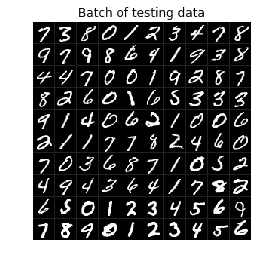

In [44]:
# 加载方法1： 对应保存方法1
from caffe2.proto import caffe2_pb2

blob = workspace.FetchBlob('data')
pyplot.figure()
pyplot.title('Batch of testing data')
_ = visualize.NCHW.ShowMultiple(blob)

workspace.ResetWorkspace()

init_net = '1-MNIST/init_net.pb'
predict_net = '1-MNIST/predict_net.pb'

test_model = model_helper.ModelHelper(name='test_model', init_params=False)

# bring in param_init_net
init_net_proto = caffe2_pb2.NetDef() # a class of NetDef
with open(init_net, 'rb') as f: 
    init_net_proto.ParseFromString(f.read()) 
tmp_param_net = core.Net(init_net_proto)
test_model.param_init_net.AppendNet(tmp_param_net)
# bring in predict net
predict_net_proto = caffe2_pb2.NetDef()
with open(predict_net, 'rb') as f:
    predict_net_proto.ParseFromString(f.read())
tmp_predict_net = core.Net(predict_net_proto)
test_model.net.AppendNet(tmp_predict_net)

workspace.RunNetOnce(test_model.param_init_net)
workspace.FeedBlob('data', data)
workspace.CreateNet(test_model.net)
workspace.RunNet(test_model.net)
workspace.FetchBlob('softmax')[0]

the blobs after reset is []
 the blobs in the workspace after loading the model is ['!!META_NET_DEF', '!!PREDICTOR_DBREADER', 'conv1', 'conv1_b', 'conv1_w', 'conv2', 'conv2_b', 'conv2_w', 'data', 'fc3', 'fc3_b', 'fc3_w', 'pool1', 'pool2', 'pred', 'pred_b', 'pred_w', 'relu3', 'softmax']
Shape of softmax is (64, 10)
Prediction is 3
Confidence is 0.9994385838508606


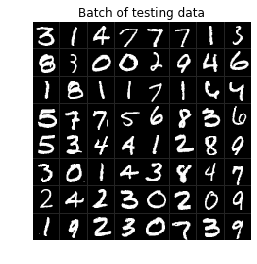

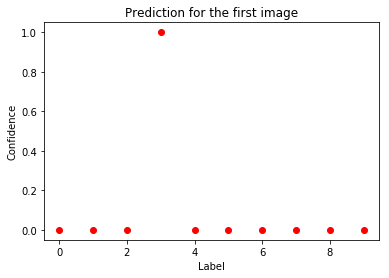

In [45]:
# 加载方法2： 对应保存方法2
blob = workspace.FetchBlob('data')
pyplot.figure()
pyplot.title('Batch of testing data')
_ = visualize.NCHW.ShowMultiple(blob)

workspace.ResetWorkspace()

print('the blobs after reset is {}'.format(workspace.Blobs()))

predict_net = pe.prepare_prediction_net('1-MNIST/mnist_model.minidb', 'minidb')
print(' the blobs in the workspace after loading the model is {}'.format(workspace.Blobs()))
workspace.FeedBlob('data', blob)

workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob('softmax')

print('Shape of softmax is {}'.format(softmax.shape))


curr_pred, curr_conf = max(enumerate(softmax[0]), key=operator.itemgetter(1))
print('Prediction is {}'.format(curr_pred))
print('Confidence is {}'.format(curr_conf))

pyplot.figure()
pyplot.title('Prediction for the first image')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
_ = pyplot.plot(softmax[0], 'ro')

In [46]:
model_path = '1-MNIST/mnist_model.minidb'

workspace.ResetWorkspace()

def load_model(model_path):
    predict_net = pe.prepare_prediction_net(model_path, 'minidb')
    return predict_net

predict_net = load_model(model_path)

In [47]:
workspace.Blobs()

['!!META_NET_DEF',
 '!!PREDICTOR_DBREADER',
 'conv1',
 'conv1_b',
 'conv1_w',
 'conv2',
 'conv2_b',
 'conv2_w',
 'data',
 'fc3',
 'fc3_b',
 'fc3_w',
 'pool1',
 'pool2',
 'pred',
 'pred_b',
 'pred_w',
 'relu3',
 'softmax']

In [48]:
workspace.FetchBlob('conv1')

b'conv1, a C++ native class of type nullptr (uninitialized).'

In [49]:
workspace.FeedBlob('data', blob)

True

In [50]:
workspace.RunNetOnce(predict_net)
workspace.FetchBlob('softmax')

array([[1.61293110e-06, 7.33086125e-08, 2.19025402e-04, 9.99438584e-01,
        4.04773672e-08, 2.17280744e-04, 3.16305160e-09, 5.35208073e-08,
        1.17675176e-04, 5.70463817e-06],
       [1.81703610e-04, 9.93783951e-01, 8.81128712e-04, 2.48122640e-04,
        5.47119824e-04, 2.46437441e-04, 1.38557889e-03, 7.23464938e-04,
        1.35792769e-03, 6.44602347e-04],
       [1.12169240e-04, 5.18395291e-06, 5.79795390e-02, 4.67913487e-05,
        9.25253868e-01, 1.81811673e-04, 9.70902760e-03, 6.96306670e-05,
        8.35807805e-05, 6.55837636e-03],
       [7.55945744e-04, 6.89428271e-06, 9.44833097e-04, 3.86382919e-04,
        3.78997038e-06, 2.50890764e-04, 1.04900676e-06, 9.78618801e-01,
        1.23222126e-04, 1.89082623e-02],
       [1.75658016e-07, 2.72379488e-08, 1.59741357e-05, 4.44006218e-05,
        3.43419893e-09, 1.62207400e-07, 2.34057808e-11, 9.99844313e-01,
        8.22374091e-07, 9.39180682e-05],
       [2.19205890e-06, 3.74484011e-06, 3.37088510e-04, 5.09927631e-04,
   

In [51]:
workspace.FetchBlob('conv1')

array([[[[-0.3490819 , -0.3490819 , -0.3490819 , ..., -0.3490819 ,
          -0.3490819 , -0.3490819 ],
         [-0.35835513, -0.37545994, -0.38402078, ..., -0.3490819 ,
          -0.3490819 , -0.3490819 ],
         [-0.71298814, -0.9411334 , -0.9273597 , ..., -0.34458   ,
          -0.3490819 , -0.3490819 ],
         ...,
         [-0.3490819 , -0.29046935, -0.31290376, ..., -0.44831896,
          -0.34867486, -0.3490819 ],
         [-0.3490819 , -0.3373713 , -0.2849806 , ..., -0.34450284,
          -0.3490819 , -0.3490819 ],
         [-0.3490819 , -0.3490819 , -0.3490819 , ..., -0.3490819 ,
          -0.3490819 , -0.3490819 ]],

        [[ 0.14271426,  0.14271426,  0.14271426, ...,  0.14271426,
           0.14271426,  0.14271426],
         [ 0.1365585 ,  0.12410991,  0.12047851, ...,  0.14271426,
           0.14271426,  0.14271426],
         [-0.12008619, -0.2736354 , -0.2899904 , ...,  0.13722621,
           0.14271426,  0.14271426],
         ...,
         [ 0.14271426,  0.02901372